In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re

In [14]:
def get_data_from_file(file_path, spmm_method, gemm_method, get_gemm_flag):
    df = pd.read_csv(file_path)
    if get_gemm_flag:
        df = df[['m', 'k', 'n', 'spmm_time', 'gemm_time']]
        df = df.rename(columns={'spmm_time': spmm_method, 'gemm_time': gemm_method})
    else:
        df = df[['m', 'k', 'n', 'spmm_time']]
        df = df.rename(columns={'spmm_time': spmm_method})
    return df

def get_data_from_file_ssmm(file_path):
    with open(file_path, 'r') as file:
        file_data = file.read()
    pattern = r"Running with m=(\d+), n=(\d+), k=(\d+).*?One iter for SSMM kernel is :([\d.]+) ms"
    matches = re.findall(pattern, file_data, re.DOTALL)
    results = [{"m": int(m), "n": int(n), "k": int(k), "ssmm": float(time)} for m, n, k, time in matches]
    results = pd.DataFrame(results)
    return results

In [15]:
directory = '../results/kernel/'
ssmm_files = [f for f in os.listdir(directory) if f.startswith('SSMM')]
ssmm_devices = [f.split('_')[1].replace('.txt', '') for f in ssmm_files]
ssmm_file_cata_df = pd.DataFrame({
    'file': ssmm_files,
    'devices': ssmm_devices
})

other_files = [f for f in os.listdir(directory) if f.endswith('.txt') and not f.startswith('SSMM')]
other_devices = [f.split('_')[3].replace('.txt', '') for f in other_files]
other_gemm_method = [os.path.splitext(f.split('_')[2])[0] for f in other_files]
other_ssmm_method = [os.path.splitext(f.split('_')[0])[0] for f in other_files]
other_file_cata_df = pd.DataFrame({
    'file': other_files,
    'devices': other_devices,
    'gemm_method': other_gemm_method,
    'ssmm_method': other_ssmm_method,
})

unique_devices = ssmm_file_cata_df['devices'].unique()
print(unique_devices)
data_dict = {}
for d in unique_devices:
    ssmm_files = ssmm_file_cata_df[ssmm_file_cata_df['devices'] == d]['file']
    other_files = other_file_cata_df[other_file_cata_df['devices'] == d]['file']
    for ssmm_file in ssmm_files:
        data = get_data_from_file_ssmm(directory + ssmm_file)
    get_gemm_flag = True
    for other_file in other_files:
        if get_gemm_flag:
            other_data = get_data_from_file(directory + other_file, other_file_cata_df[other_file_cata_df['file'] == other_file]['ssmm_method'].values[0], other_file_cata_df[other_file_cata_df['file'] == other_file]['gemm_method'].values[0], get_gemm_flag)
            data = pd.merge(data, other_data, on=['m', 'k', 'n'])
            get_gemm_flag = False
        else:
            other_data = get_data_from_file(directory + other_file, other_file_cata_df[other_file_cata_df['file'] == other_file]['ssmm_method'].values[0], other_file_cata_df[other_file_cata_df['file'] == other_file]['gemm_method'].values[0], get_gemm_flag)
            data = pd.merge(data, other_data, on=['m', 'k', 'n'])

    data['shape'] = data.iloc[:, :3].astype(str).apply('_'.join, axis=1)
    data['num_blocks'] = data['m'] // 128 * data['n'] // 64
    columns_to_norm = ['ssmm', 'Venom', 'cuBlas', 'Sputnik', 'cuSparseLt', 'cuSparseLtsearched']
    
    for column in columns_to_norm:
        data[column] = data['m'] * data['n'] * (2 * data['k'] - 1) / ((data[column] * 1e-3)) * 1e-12

    data_dict[d] = data

['NVIDIA.GeForce.RTX.3090' 'NVIDIA.GeForce.RTX.4070.SUPER'
 'NVIDIA.GeForce.RTX.4090' 'NVIDIA.A100-PCIE-40GB']


[(         Sputnik     cuBLAS  cuSPARSELt       VENOM    Samoyeds
m                                                              
256    14.114618  62.485075  102.310029  162.126033  146.561768
512    14.940571  66.559873  125.326651  201.283460  282.068464
1024   15.111368  70.319002  127.485923  213.758899  441.265812
2048   14.690363  74.277279  136.644668  227.313921  629.303099
4096   13.951320  76.698466  145.011345  244.861546  545.349901
8192   13.523542  78.175392  146.055518  251.612931  625.035482
16384  13.016699  78.510807   93.278563  253.713799  613.990040, 0, 'm', '(a) k=4096,n=4096'), (         Sputnik     cuBLAS  cuSPARSELt       VENOM    Samoyeds
k                                                              
256    25.899917  62.628076  108.005016  175.198735  225.891769
512    27.779725  65.886960  122.951831  211.146840  347.152025
1024   27.317675  68.659145  131.466878  229.669644  435.870290
2048   20.171140  73.842507  138.241762  233.729556  509.289910
4096  

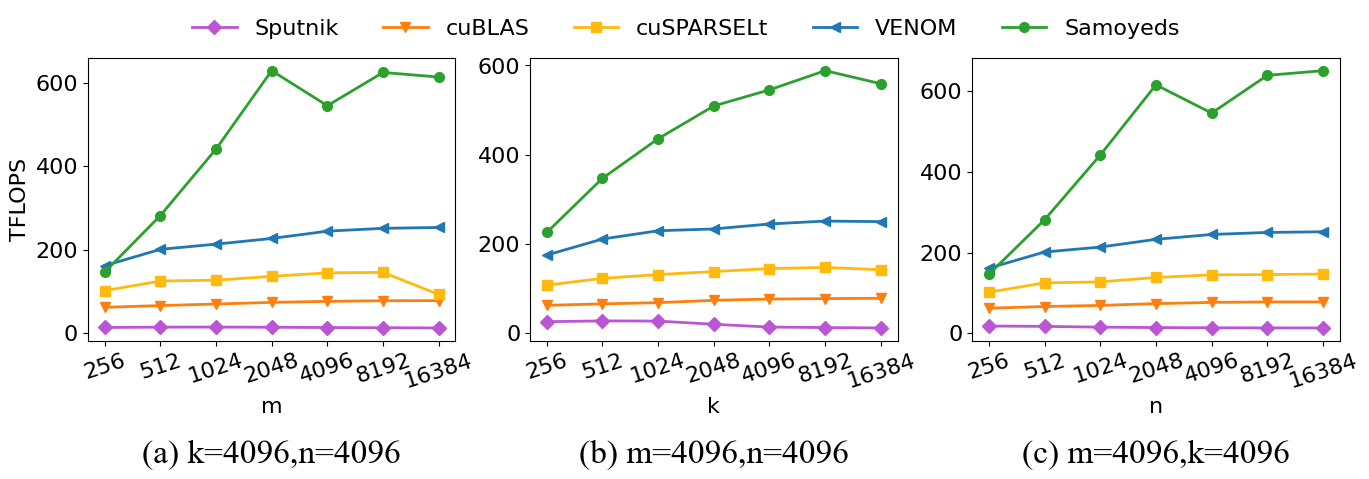

In [16]:
plt.rcParams["font.size"] = 16

name_mapping = {'Sputnik': 'Sputnik', 'cuBlas': 'cuBLAS', 'cuSparseLtsearched': 'cuSPARSELt', 'Venom': 'VENOM', 'ssmm': 'Samoyeds'}

# ========================= data_4070s_m =========================
data_4070s_m = data_dict['NVIDIA.GeForce.RTX.4070.SUPER']
data_4070s_m = data_4070s_m[data_4070s_m['k'] == 4096]
data_4070s_m = data_4070s_m[data_4070s_m['n'] == 4096]
data_4070s_m = data_4070s_m[['m', 'Sputnik', 'cuBlas', 'cuSparseLtsearched', 'Venom', 'ssmm']]

data_4070s_m = data_4070s_m.rename(columns=name_mapping)
data_4070s_m.set_index('m', inplace=True)

# ========================= data_4070s_k =========================
data_4070s_k = data_dict['NVIDIA.GeForce.RTX.4070.SUPER']
data_4070s_k = data_4070s_k[data_4070s_k['m'] == 4096]
data_4070s_k = data_4070s_k[data_4070s_k['n'] == 4096]
data_4070s_k = data_4070s_k[['k', 'Sputnik', 'cuBlas', 'cuSparseLtsearched', 'Venom', 'ssmm']]

data_4070s_k = data_4070s_k.rename(columns=name_mapping)
data_4070s_k.set_index('k', inplace=True)

# ========================= data_4070s_n =========================
# select all kernel profile results with `m=4096 k=4096`
data_4070s_n = data_dict['NVIDIA.GeForce.RTX.4070.SUPER']
data_4070s_n = data_4070s_n[data_4070s_n['m'] == 4096]
data_4070s_n = data_4070s_n[data_4070s_n['k'] == 4096]
data_4070s_n = data_4070s_n[['n', 'Sputnik', 'cuBlas', 'cuSparseLtsearched', 'Venom', 'ssmm']]

data_4070s_n = data_4070s_n.rename(columns=name_mapping)
data_4070s_n.set_index('n', inplace=True)

para_list = [(data_4070s_m,0,'m','(a) k=4096,n=4096'), (data_4070s_k,1,'k','(b) m=4096,n=4096'), (data_4070s_n,2,'n','(c) m=4096,k=4096')]

print(para_list)
fig, axs = plt.subplots(1, 3, figsize=(14, 5))

for (data_df, idx, x_label, title) in para_list:
    markers = ['D', 'v', 's', '<', 'o']

    colors = ['#BA55D3', '#ff7f0e', '#ffba0d', '#1f77b4', '#2ca02c']
    x = np.linspace(0, 1, len(data_df))
    for i, column in enumerate(data_df.columns):
        axs[idx].plot(x, data_df[column], linewidth=2, marker=markers[i % len(markers)], markersize=7, label=column, color=colors[i])
        
    # Set labels and title with enhanced formatting
    if idx == 0:
        axs[idx].set_ylabel("TFLOPS")
    axs[idx].set_xlabel(x_label)
    axs[idx].xaxis.set_label_coords(0.5, -0.2) 
    axs[idx].text(0.5, -0.4, title, ha='center', va='center', transform=axs[idx].transAxes, fontdict={'family':'Times New Roman', 'size': 24})  
    
    axs[idx].set_xticks(x)
    axs[idx].set_xticklabels(data_4070s_m.index, rotation=18)
    
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.95), ncol=5, frameon=False)

plt.tight_layout(w_pad=0)

plt.show()